In [1]:
import tensorflow
import keras

Using TensorFlow backend.


In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [132]:
import IPython

In [3]:
my_seed = 42 # 480 could work too
random.seed(my_seed)
np.random.seed(my_seed)
tensorflow.set_random_seed(my_seed)

## Import data & separate train and test

In [5]:
df = pd.read_csv('all_data_info.csv')
mask = (df['new_filename'].str.startswith('3') & df['in_train'])
train_3_df = df[mask]
top10 = train_3_df.groupby('artist').count().sort_values(by='title', ascending=False).head(10)

In [29]:
rand_top10 = list(top10.index)
random.shuffle(rand_top10)
print(rand_top10)

['Marc Chagall', 'Martiros Saryan', 'Pyotr Konchalovsky', 'Theophile Steinlen', 'Camille Corot', 'Giovanni Battista Piranesi', 'Eyvind Earle', 'Pierre-Auguste Renoir', 'Camille Pissarro', 'Claude Monet']


In [35]:
data_dir = '/home/mo/Downloads/painters/'
train_dir = data_dir + 'train_3/'

working_train_dir = data_dir + "train/"
working_test_dir = data_dir + "test/"
if (os.path.isdir(working_train_dir) == False):
    os.mkdir(working_train_dir)
    print("created " + working_train_dir)
else:
    print(working_train_dir + " exists")
if (os.path.isdir(working_test_dir) == False):
    os.mkdir(working_test_dir)
    print("created " + working_test_dir)
else:
    print(working_test_dir + " exists")

artist_dirs = []
test_artist_dirs = []
for a in top10.index:
    artist_dirs.append(working_train_dir + a)
    test_artist_dirs.append(working_test_dir + a)

created /home/mo/Downloads/painters/train/
created /home/mo/Downloads/painters/test/


In [36]:
for d in artist_dirs:    
    if (os.path.isdir(d) == False):
        os.mkdir(d)
        print("created " + d)
    else:
        print(d + " exists")

# same for test data 
for d in test_artist_dirs:    
    if (os.path.isdir(d) == False):
        os.mkdir(d)
        print("created " + d)
    else:
        print(d + " exists")

created /home/mo/Downloads/painters/train/Camille Corot
created /home/mo/Downloads/painters/train/Eyvind Earle
created /home/mo/Downloads/painters/train/Pierre-Auguste Renoir
created /home/mo/Downloads/painters/train/Martiros Saryan
created /home/mo/Downloads/painters/train/Camille Pissarro
created /home/mo/Downloads/painters/train/Claude Monet
created /home/mo/Downloads/painters/train/Pyotr Konchalovsky
created /home/mo/Downloads/painters/train/Giovanni Battista Piranesi
created /home/mo/Downloads/painters/train/Theophile Steinlen
created /home/mo/Downloads/painters/train/Marc Chagall
created /home/mo/Downloads/painters/test/Camille Corot
created /home/mo/Downloads/painters/test/Eyvind Earle
created /home/mo/Downloads/painters/test/Pierre-Auguste Renoir
created /home/mo/Downloads/painters/test/Martiros Saryan
created /home/mo/Downloads/painters/test/Camille Pissarro
created /home/mo/Downloads/painters/test/Claude Monet
created /home/mo/Downloads/painters/test/Pyotr Konchalovsky
create

In [37]:
from shutil import copy2

test_num = 10

for i in range(len(top10.index)):
    test_count = 0
    train_count = 0
    files = list(train_3_df[(train_3_df['artist'] == top10.index[i])]['new_filename'])
    random.shuffle(files)
    for f in files:
        if (test_count < test_num) and os.path.exists(train_dir+f) and not os.path.exists(test_artist_dirs[i]+f):
            copy2(train_dir+f, test_artist_dirs[i])
            test_count +=1
        elif os.path.exists(train_dir+f) and not os.path.exists(artist_dirs[i]+f):
            copy2(train_dir+f, artist_dirs[i])
            train_count +=1
    print('Copied to %s : %s images' % (str(test_artist_dirs[i]), str(test_count)))
    print('Copied to %s : %s images' % (str(artist_dirs[i]), str(train_count)))

Copied to /home/mo/Downloads/painters/test/Camille Corot : 10 images
Copied to /home/mo/Downloads/painters/train/Camille Corot : 50 images
Copied to /home/mo/Downloads/painters/test/Eyvind Earle : 10 images
Copied to /home/mo/Downloads/painters/train/Eyvind Earle : 41 images
Copied to /home/mo/Downloads/painters/test/Pierre-Auguste Renoir : 10 images
Copied to /home/mo/Downloads/painters/train/Pierre-Auguste Renoir : 41 images
Copied to /home/mo/Downloads/painters/test/Martiros Saryan : 10 images
Copied to /home/mo/Downloads/painters/train/Martiros Saryan : 40 images
Copied to /home/mo/Downloads/painters/test/Camille Pissarro : 10 images
Copied to /home/mo/Downloads/painters/train/Camille Pissarro : 37 images
Copied to /home/mo/Downloads/painters/test/Claude Monet : 10 images
Copied to /home/mo/Downloads/painters/train/Claude Monet : 36 images
Copied to /home/mo/Downloads/painters/test/Pyotr Konchalovsky : 10 images
Copied to /home/mo/Downloads/painters/train/Pyotr Konchalovsky : 36 im

## Import the model for transfer learning

In [38]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

num_classes = 10 # picasso or not picasso

# https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
weights_notop_path = ''

# declare new Sequential model
# meaning each layer is in sequence, one after the other. 
# apparently there can be non-sequential neural networks... wow!
model = Sequential()

# now let's set up the first layers
model.add(ResNet50(    # add a whole ResNet50 model
  include_top=False,          # without the last layer
  weights='imagenet', # and with the "notop" weights file
  pooling='avg' # means collapse extra "channels" into 1D tensor by taking an avg across channels
))


# Now lets add a "Dense" layer to make predictions
model.add(Dense(
  num_classes, # this last layer just has 2 nodes
  activation='softmax' # apply softmax function to turn values of this layer into probabilities
))

# do not train the first layer
# because it is already smart
# it learned cool patterns from ImageNet
model.layers[0].trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [39]:
model.compile(
  optimizer='sgd', # stochastic gradient descent (how to update Dense connections during training)
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

In [133]:
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_size = 224

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   rotation_range=20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2)

train_generator_with_aug = data_generator_with_aug.flow_from_directory(
        working_train_dir,
        target_size=(image_size, image_size),
        batch_size=4,
        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
        working_test_dir,
        target_size=(image_size, image_size),
        class_mode='categorical')

Found 387 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


## Train the model

In [134]:
history_aug = model.fit_generator(
        train_generator_with_aug,
        steps_per_epoch=10,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=1)

Epoch 1/20
97/97 [==============================] - 66s 682ms/step - loss: 0.5140 - acc: 0.8398 - val_loss: 1.0153 - val_acc: 0.7200
Epoch 2/20
97/97 [==============================] - 67s 695ms/step - loss: 0.4524 - acc: 0.8346 - val_loss: 1.3937 - val_acc: 0.7100
Epoch 3/20
97/97 [==============================] - 67s 695ms/step - loss: 0.5465 - acc: 0.8217 - val_loss: 1.1393 - val_acc: 0.7200
Epoch 4/20
97/97 [==============================] - 71s 732ms/step - loss: 0.4900 - acc: 0.8346 - val_loss: 0.7515 - val_acc: 0.7200
Epoch 5/20
97/97 [==============================] - 64s 663ms/step - loss: 0.4876 - acc: 0.8346 - val_loss: 0.8002 - val_acc: 0.6900
Epoch 6/20
97/97 [==============================] - 64s 660ms/step - loss: 0.4092 - acc: 0.8656 - val_loss: 1.0702 - val_acc: 0.7100
Epoch 7/20
97/97 [==============================] - 63s 649ms/step - loss: 0.4732 - acc: 0.8450 - val_loss: 0.9031 - val_acc: 0.7200
Epoch 8/20
97/97 [==============================] - 62s 640ms/step - 

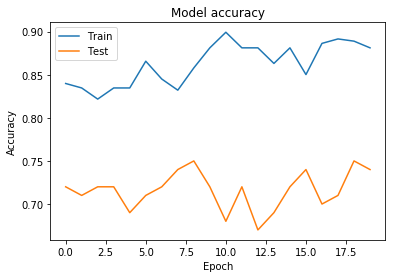

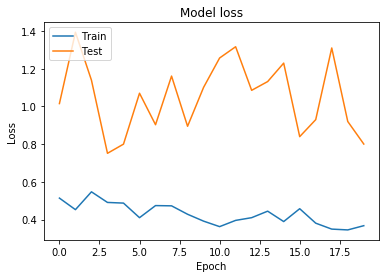

In [135]:
plt.plot(history_aug.history['acc'])
plt.plot(history_aug.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Check the predictions

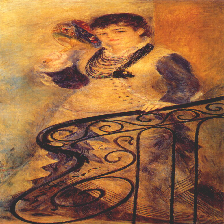

In [163]:
import PIL.Image as Image

rand_top10 = list(top10.index)
random.shuffle(rand_top10)
true_artist = rand_top10[0]
pictures = list(train_3_df[(train_3_df['artist'] == true_artist)]['new_filename'])
img = random.choice(pictures)
image_name = train_dir + img
image = Image.open(image_name).resize((image_size, image_size))
image

In [164]:
print('Artist: ' + true_artist)

Artist: Pierre-Auguste Renoir


In [165]:
image = np.array(image)/255.0
result = model.predict(image[np.newaxis, ...])
predicted_class = np.argmax(result[0], axis=-1)
result

array([[3.0832937e-01, 8.3349572e-05, 3.8951669e-08, 6.9100481e-01,
        4.6253850e-09, 3.8588684e-04, 3.0176765e-05, 3.5785450e-09,
        3.0981444e-06, 1.6332880e-04]], dtype=float32)

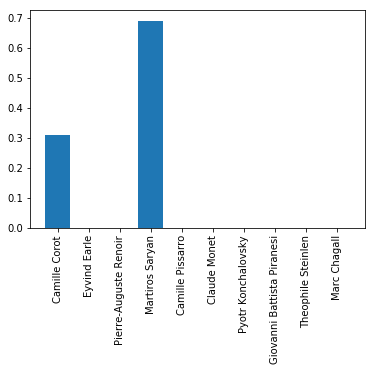

In [166]:
plt.bar(range(10), result[0])
plt.xticks(range(10), top10.index, rotation=90)
plt.show()